In [2]:
import numpy as np
np.set_printoptions(precision=2)

import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")

import os,gc,glob

In [3]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier # Used for imputing rare / missing values


from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge 

In [4]:
train = pd.read_csv('train.csv', index_col = 0, parse_dates=[1])
test = pd.read_csv('test.csv', index_col = 0, parse_dates=[1])
df = pd.concat((test, train), ignore_index=True,sort=False)

train.shape, test.shape

((137, 42), (100000, 41))

In [5]:
train.head()

,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1999-07-17,İstanbul,Big Cities,IL,4,5.000,4.000,4.000,2,2,5,4,5,5,3,5,5.000,1,2,2,2,4,5,4,1,3,3,1,1,1.000,4.000,2.000,3.000,5,3,4,5,5,4,3,4,5653753.000
1,2008-02-14,Ankara,Big Cities,FC,4,5.000,4.000,4.000,1,2,5,5,5,5,1,5,5.000,0,0,0,0,0,3,2,1,3,2,0,0,0.000,0.000,3.000,3.000,0,0,0,0,0,0,0,0,6923131.000
2,2013-03-09,Diyarbakır,Other,IL,2,4.000,2.000,5.000,2,3,5,5,5,5,2,5,5.000,0,0,0,0,0,1,1,1,1,1,0,0,0.000,0.000,1.000,3.000,0,0,0,0,0,0,0,0,2055379.000
3,2012-02-02,Tokat,Other,IL,6,4.500,6.000,6.000,4,4,10,8,10,10,8,10,7.500,6,4,9,3,12,20,12,6,1,10,2,2,2.500,2.500,2.500,7.500,25,12,10,6,18,12,12,6,2675511.000
4,2009-05-09,Gaziantep,Other,IL,3,4.000,3.000,4.000,2,2,5,5,5,5,2,5,5.000,2,1,2,1,4,2,2,1,2,1,2,3,3.000,5.000,1.000,3.000,5,1,3,2,3,4,3,3,4316715.000


In [6]:
df.describe()

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
count,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,137.000
mean,4.088,4.428,4.215,4.396,1.990,2.883,5.301,4.931,5.252,5.459,3.312,5.062,5.087,1.280,1.306,1.747,1.157,1.709,5.191,4.571,2.542,2.430,3.640,1.235,1.244,1.280,1.164,3.234,3.084,2.084,1.194,1.943,0.988,2.109,1.833,1.969,0.974,4453532.613
std,2.813,1.429,0.842,1.036,1.066,1.533,2.179,1.719,1.703,1.764,2.068,1.766,0.979,2.497,2.167,3.172,2.432,3.031,5.785,3.613,2.525,1.363,4.719,2.098,2.085,2.310,2.179,2.137,1.784,4.311,2.310,3.973,1.535,4.686,3.229,3.806,1.677,2576071.596
min,1.000,1.000,0.000,2.000,1.000,1.000,1.000,1.000,4.000,4.000,1.000,2.000,3.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1149870.000
25%,2.000,4.000,4.000,4.000,1.000,2.000,5.000,4.000,4.000,5.000,2.000,4.000,5.000,0.000,0.000,0.000,0.000,0.000,2.000,2.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,2.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2999068.000
50%,3.000,5.000,4.000,4.000,2.000,2.000,5.000,5.000,5.000,5.000,3.000,5.000,5.000,0.000,0.000,0.000,0.000,0.000,3.000,4.000,2.000,2.000,2.000,0.000,0.000,0.000,0.000,3.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3939804.000
75%,4.000,5.000,4.000,5.000,2.000,4.000,5.000,5.000,5.000,5.000,4.000,5.000,5.000,2.000,2.000,3.000,2.000,4.000,5.000,5.000,3.000,3.000,4.000,2.000,2.000,2.000,2.000,4.000,3.000,3.000,1.000,3.000,2.000,3.000,4.000,3.000,2.000,5166635.000
max,15.000,7.500,7.500,7.500,8.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,7.500,15.000,10.000,15.000,15.000,15.000,25.000,15.000,15.000,5.000,25.000,10.000,10.000,12.500,12.500,12.500,10.000,25.000,15.000,25.000,6.000,30.000,15.000,20.000,8.000,19696939.000


In [7]:
last_date = df["Open Date"].max()
df["Open Date"] = last_date - df["Open Date"] 
df["Open Date"] = df["Open Date"].dt.days + 1 

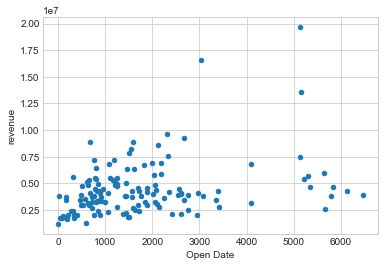

In [8]:
df[["Open Date", "revenue"]].plot(x="Open Date", y="revenue", kind='scatter')

In [9]:
df["Log Days Opened"] = df["Open Date"].apply(np.log)

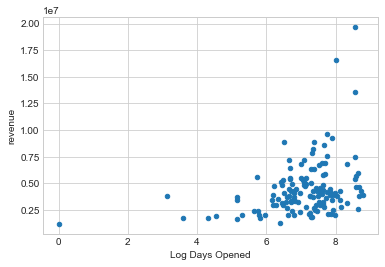

In [10]:
df[["Log Days Opened", "revenue"]].plot(x="Log Days Opened", y="revenue", kind='scatter')

In [11]:
df = df.drop(["Open Date"], axis=1)

In [12]:
from scipy import stats

In [13]:
col_P = [col for col in df.columns if col[0]=='P']

In [14]:
#to capture pattern in rows || similar to np.nan flag

mode_P_row = stats.mode(df[col_P], axis=1)[0]

stats.mode(mode_P_row) 

#seems many row have zero behavior

ModeResult(mode=array([[0.]]), count=array([[68402]]))

In [15]:
df['zeros'] = (df[col_P] == 0).sum(1)

In [16]:
df = df.join(pd.get_dummies(df['City Group'], prefix="CG"))
df = df.join(pd.get_dummies(df['Type'], prefix="T"))

In [17]:
train.Type.value_counts()

FC    76
IL    60
DT     1
Name: Type, dtype: int64

In [18]:
#City Group  have only 2 cat so we can drop one
# Types have unseen category in test set 
df = df.drop(["City Group", "Type", "CG_Other", "T_MB", "T_DT"], axis=1)
df.shape

(100137, 44)

In [19]:
#Many unseen category for City 
#replacing with freq

In [20]:
city_counts = test["City"].value_counts(normalize=True).add(train["City"].value_counts(normalize=True), fill_value=0)
df["City"] = df["City"].replace(city_counts)

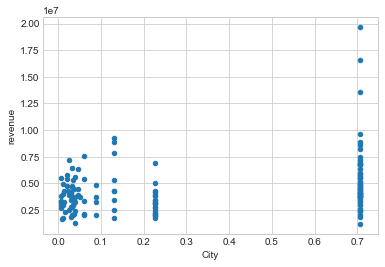

In [21]:
df[["City", "revenue"]].plot(x="City", y="revenue", kind='scatter')

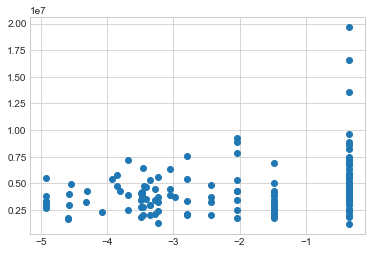

In [22]:
plt.scatter(df["City"].apply(np.log), df.revenue)

In [23]:
# Take log of city count so that the marginal effect decreases
df["Log City Count"] = df["City"].apply(np.log) 
df = df.drop(["City"], axis=1)

In [24]:
#predict unseen Types

tofit = df.loc[((df.T_FC==1) | (df.T_IL==1)) & (pd.notnull(df.revenue))] #fit train
tofill = df.loc[((df.T_FC==0) & (df.T_IL==0))]

In [25]:
y = tofit.T_FC
X = tofit.drop(["T_FC", "T_IL", "revenue"], axis=1)

In [26]:
SEED = 0
model_grid = {'max_depth': [None, 8], 'min_samples_split': [4,9,16], 'min_samples_leaf':[1,4], 'max_features':['sqrt', 0.5, None]}
type_model = ExtraTreesClassifier(n_estimators=25, random_state=SEED)

grid = RandomizedSearchCV(type_model, model_grid, n_iter=10, cv=5, scoring="roc_auc")
grid.fit(X, y)

#refit = True by default
type_model.set_params(**grid.best_params_)
type_model.fit(X, y)

print("Best parameters for Type Model:")
print(grid.best_params_)

Best parameters for Type Model:
{'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 8}


C:\ProgramData\Anaconda3\envs\do_not\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [27]:
imputations = type_model.predict(tofill.drop(["T_FC", "T_IL", "revenue"], axis=1))
df.loc[(df.T_FC==0) & (df.T_IL==0), "T_FC"] = imputations
df = df.drop(["T_IL"], axis=1)

In [28]:
df.T_FC.mean(), np.mean(imputations)

(0.5881442423879285, 0.7100591715976331)

In [29]:
# Now binarize the "P" columns with dummy variables
print ("Pre-binarizing columns:{}".format(len(df.columns)) )
for col in df.columns:
    if col[0] == 'P':
        print ("{}, {}, 'unique values'".format(col,len(df[col].unique())))
        df = df.join(pd.get_dummies(df[col], prefix=col))
        df = df.drop([col, df.columns[-1]], axis=1)
print ("Post-binarizing columns:{}".format(len(df.columns)))

Pre-binarizing columns:43
P1, 9, 'unique values'
P2, 9, 'unique values'
P3, 8, 'unique values'
P4, 7, 'unique values'
P5, 7, 'unique values'
P6, 8, 'unique values'
P7, 7, 'unique values'
P8, 8, 'unique values'
P9, 5, 'unique values'
P10, 4, 'unique values'
P11, 8, 'unique values'
P12, 7, 'unique values'
P13, 5, 'unique values'
P14, 10, 'unique values'
P15, 9, 'unique values'
P16, 10, 'unique values'
P17, 10, 'unique values'
P18, 9, 'unique values'
P19, 9, 'unique values'
P20, 9, 'unique values'
P21, 9, 'unique values'
P22, 5, 'unique values'
P23, 9, 'unique values'
P24, 9, 'unique values'
P25, 9, 'unique values'
P26, 10, 'unique values'
P27, 10, 'unique values'
P28, 9, 'unique values'
P29, 8, 'unique values'
P30, 10, 'unique values'
P31, 10, 'unique values'
P32, 10, 'unique values'
P33, 7, 'unique values'
P34, 11, 'unique values'
P35, 8, 'unique values'
P36, 10, 'unique values'
P37, 8, 'unique values'
Post-binarizing columns:279


In [30]:
# Scaling
min_max_scaler = MinMaxScaler()
# Not scaling o/p
rev = df.revenue
df = df.drop(['revenue'], axis=1)

df = pd.DataFrame(data = min_max_scaler.fit_transform(df), columns = df.columns, index=df.index)
df = df.join(rev)


df.describe()

C:\ProgramData\Anaconda3\envs\do_not\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Log Days Opened,zeros,CG_Big Cities,T_FC,Log City Count,P1_1,P1_2,P1_3,P1_4,P1_5,P1_6,P1_9,P1_12,P2_1.0,P2_1.5,P2_2.0,P2_3.0,P2_4.0,P2_4.5,P2_5.0,P2_6.0,P3_0.0,P3_2.0,P3_3.0,P3_4.0,P3_4.5,P3_5.0,P3_6.0,P4_2.0,P4_3.0,P4_4.0,P4_4.5,P4_5.0,P4_6.0,P5_1,P5_2,P5_3,P5_4,P5_5,P5_6,P6_1,P6_2,P6_3,P6_4,P6_5,P6_6,P6_8,P7_1,P7_2,P7_3,P7_4,P7_5,P7_6,P8_1,P8_2,P8_3,P8_4,P8_5,P8_6,P8_8,P9_4,P9_5,P9_6,P9_8,P10_4,P10_5,P10_8,P11_1,P11_2,P11_3,P11_4,P11_5,P11_6,P11_8,P12_2,P12_3,P12_4,P12_5,P12_6,P12_8,P13_3.0,P13_4.0,P13_5.0,P13_6.0,P14_0,P14_1,P14_2,P14_3,P14_4,P14_5,P14_6,P14_9,P14_12,P15_0,P15_1,P15_2,P15_3,P15_4,P15_5,P15_6,P15_8,P16_0,P16_1,P16_2,P16_3,P16_4,P16_5,P16_6,P16_9,P16_12,P17_0,P17_1,P17_2,P17_3,P17_4,P17_5,P17_6,P17_9,P17_12,P18_0,P18_1,P18_2,P18_3,P18_4,P18_5,P18_9,P18_12,P19_1,P19_2,P19_3,P19_4,P19_5,P19_10,P19_15,P19_20,P20_1,P20_2,P20_3,P20_4,P20_5,P20_6,P20_9,P20_12,P21_1,P21_2,P21_3,P21_4,P21_5,P21_6,P21_9,P21_12,P22_1,P22_2,P22_3,P22_4,P23_1,P23_2,P23_3,P23_4,P23_5,P23_10,P23_15,P23_20,P24_0,P24_1,P24_2,P24_3,P24_4,P24_5,P24_6,P24_8,P25_0,P25_1,P25_2,P25_3,P25_4,P25_5,P25_6,P25_8,P26_0.0,P26_1.0,P26_2.0,P26_2.5,P26_3.0,P26_4.0,P26_5.0,P26_7.5,P26_10.0,P27_0.0,P27_1.0,P27_2.0,P27_2.5,P27_3.0,P27_4.0,P27_5.0,P27_7.5,P27_10.0,P28_1.0,P28_2.0,P28_2.5,P28_3.0,P28_4.0,P28_5.0,P28_7.5,P28_10.0,P29_0.0,P29_1.0,P29_2.0,P29_2.5,P29_3.0,P29_5.0,P29_7.5,P30_0,P30_1,P30_2,P30_3,P30_4,P30_5,P30_10,P30_15,P30_20,P31_0,P31_1,P31_2,P31_3,P31_4,P31_5,P31_6,P31_9,P31_12,P32_0,P32_1,P32_2,P32_3,P32_4,P32_5,P32_10,P32_15,P32_20,P33_0,P33_1,P33_2,P33_3,P33_4,P33_5,P34_0,P34_1,P34_2,P34_3,P34_4,P34_5,P34_6,P34_12,P34_18,P34_24,P35_0,P35_1,P35_2,P35_3,P35_4,P35_5,P35_12,P36_0,P36_1,P36_2,P36_3,P36_4,P36_5,P36_8,P36_12,P36_16,P37_0,P37_1,P37_2,P37_3,P37_4,P37_5,P37_6,revenue
count,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,100137.000,10013

In [31]:

train = df.loc[pd.notnull(df.revenue)]
test = df.loc[pd.isnull(df.revenue)].drop(['revenue'], axis=1)

#scaling o/p
y = train.revenue.apply(np.sqrt)
X = train.drop(["revenue"], axis=1)

In [32]:
from sklearn.metrics import mean_squared_error, make_scorer
make_scorer(mean_squared_error, greater_is_better=False)

make_scorer(mean_squared_error, greater_is_better=False)

In [33]:
model_grid = [{'normalize': [True, False], 'alpha': np.logspace(0,10)}]
model = Ridge()

#less data so LeaveOneOut
grid = GridSearchCV(model, model_grid,  scoring=make_scorer(mean_squared_error, greater_is_better=False), cv=LeaveOneOut())


In [34]:
grid.fit(X, y)
print("Best parameters set found on development set:")
print(grid.best_params_)
model.set_params(**grid.best_params_)
model.fit(X, y)

Best parameters set found on development set:
{'alpha': 4.094915062380426, 'normalize': True}


Ridge(alpha=4.094915062380426, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [35]:
submission = pd.DataFrame(columns=['Prediction'],index=test.index, data=model.predict(test))
submission.Prediction = submission.Prediction.apply(np.square)
submission.index.name='Id'
submission.to_csv("TFI_Ridge_2.csv")
submission.describe().astype(int)

,Prediction
count,100000
mean,4299764
std,646029
min,2172709
25%,3872360
50%,4240721
75%,4648539
max,8875742


In [36]:
train.revenue.describe()

count        137.000
mean     4453532.613
std      2576071.596
min      1149870.000
25%      2999068.000
50%      3939804.000
75%      5166635.000
max     19696939.000
Name: revenue, dtype: float64